Start with autoreload magic; this reloads modules automatically before entering the execution of code and thus enabled development in modules like util.py

In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import os
from glob import glob

import numpy as np
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt

import config

import util

In [25]:
obspack_dir = "/glade/work/mclong/sno-analysis/obspack_co2_1_GLOBALVIEWplus_v7.0_2021-08-18/data/nc"
obspack_filenames = [ # now including aircraft
    f"{obspack_dir}/co2_alt_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_brw_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_cba_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_cgo_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_kum_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_ljo_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_mlo_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_psa_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_smo_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_spo_surface-flask_4_representative.nc",
    f"{obspack_dir}/co2_hip_aircraft-insitu_59_allvalid.nc",
    f"{obspack_dir}/co2_orc_aircraft-insitu_3_allvalid-merge10.nc",
    f"{obspack_dir}/co2_tom_aircraft-insitu_1_allvalid.nc",
    f"{obspack_dir}/co2_gould_shipboard-insitu_1_allvalid.nc",
    f"{obspack_dir}/co2_aoa_aircraft-flask_19_allvalid.nc",
]

obspack_files = {}
station_list = []
for f in obspack_filenames:
    stn = os.path.basename(f).split('_')[1]
    station_list.append(stn)
    obspack_files[stn] = os.path.basename(f)

### Contribution details
- 570 obspack files, of which 59 are custom "alltimes.nc" files with hourly output at fixed stations (ObsPack 7.0 has 524 records)
- variable ‘modelsamplesensemble_forecast’ contains the forward tracers in this order:
    - apo_jena=1
    - o2_cesm=2
    - co2_cesm=3
    - n2_cesm=4
    - o2_gk01r16=5
    - co2_somffn=6
    - n2_era=7
    - co2_oco2mip=8
    - co2_gridfed=9
    - o2_gridfed=10
    - co2bg=11 (this is the 400 ppm field)
    - co2bg=12 (this is the CTE one, from our init field in 2000)
    - co2_bio=13
    - co2_ocn=14
    - co2_fire=15
    - co2_fossil=16
- also including 3D fields (one netcdf file per day)
- files also include pressure, temperature, humidity, hz wind, and BL height

In [26]:
sno_vars = [
    'apo_jena',
    'o2_cesm', 
    'co2_cesm', 
    'n2_cesm', 
    'o2_gk01r16',  
    'co2_somffn', 
    'n2_era', 
    'co2_oco2mip', 
    'co2_gridfed', 
    'o2_gridfed',   
] # without derived vars
# ordered to match indexing in modelsamplesensemble

X_O2 = 0.2094 

droot = "/glade/campaign/eol/raf/stephens/longcoll/apo-simulation-data/CTE_TM5/full_obspack"

station_records = {}
for station in station_list:

    path = f"{droot}/{obspack_files[station]}"
    print(path)
    ds = xr.open_dataset(path)

    # get time as coordinate
    time = ds.time
    time.name = 'obs'
    ds['obs'] = time
    ds = ds.drop('time').rename({'obs': 'time'})

    # # get rid of missing value codes
    # _FillValue = -999999
    # for v in sno_vars:
    #     ds[v] = ds[v].where(ds[v] != _FillValue)

    # subtract off background value    
    # for v in sno_vars:
    #     ds[v]=ds[v]-400.0 

    # assign tracer names
    for counter, v in enumerate(sno_vars):
         ds[v] = ds['modelsamplesensemble_forecast'][:,counter]*1E6-400
       
    ## all original variables are Inf from  1996.681 - 1999.973, then exist for 2000.010 onward
    ds=ds.where(ds.time_components[:,0]>2000,drop=True)
    
    # convert apo_jena to per meg
    ds['apo_jena'] = ds['apo_jena']/X_O2
    
    # add derived APO variables

    ds['apo_cesm'] = util.compute_apo (
        o2=ds['o2_cesm'],
        co2=ds['co2_cesm'],
        n2=ds['n2_cesm']
    )

    ds['apo_diss'] = util.compute_apo (
        o2=ds['o2_gk01r16'],
        co2=ds['co2_somffn'],
        n2=ds['n2_era']
    )

    ds['apo_gridfed'] = util.compute_apo (
        o2=ds['o2_gridfed'],
        co2=ds['co2_gridfed'],
        n2=0.0
    )

    ds['apo_oco2mip'] = util.compute_apo (
        o2=ds['co2_oco2mip'] * -1.4,
        co2=ds['co2_oco2mip'],
        n2=0.0
    )

    ds.to_netcdf(f"inverse_model_obspack_files/CTE_TM5/{obspack_files[station]}")
    
    station_records[station] = ds

/glade/campaign/eol/raf/stephens/longcoll/apo-simulation-data/CTE_TM5/full_obspack/co2_alt_surface-flask_4_representative.nc
/glade/campaign/eol/raf/stephens/longcoll/apo-simulation-data/CTE_TM5/full_obspack/co2_brw_surface-flask_4_representative.nc
/glade/campaign/eol/raf/stephens/longcoll/apo-simulation-data/CTE_TM5/full_obspack/co2_cba_surface-flask_4_representative.nc
/glade/campaign/eol/raf/stephens/longcoll/apo-simulation-data/CTE_TM5/full_obspack/co2_cgo_surface-flask_4_representative.nc
/glade/campaign/eol/raf/stephens/longcoll/apo-simulation-data/CTE_TM5/full_obspack/co2_kum_surface-flask_4_representative.nc
/glade/campaign/eol/raf/stephens/longcoll/apo-simulation-data/CTE_TM5/full_obspack/co2_ljo_surface-flask_4_representative.nc
/glade/campaign/eol/raf/stephens/longcoll/apo-simulation-data/CTE_TM5/full_obspack/co2_mlo_surface-flask_4_representative.nc
/glade/campaign/eol/raf/stephens/longcoll/apo-simulation-data/CTE_TM5/full_obspack/co2_psa_surface-flask_4_representative.nc


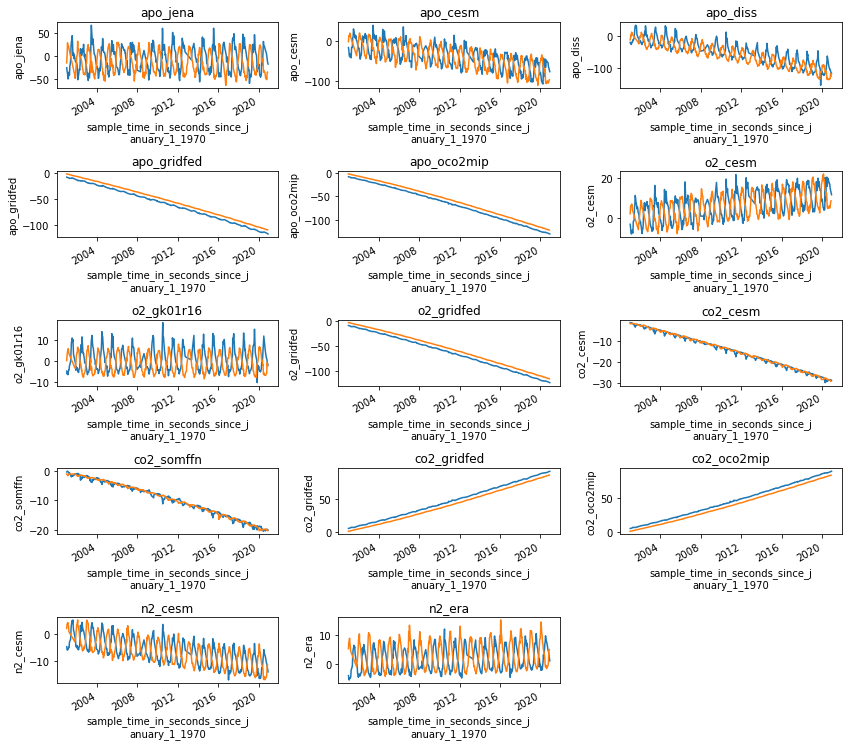

In [27]:
# plot timeseries

sno_vars = [
    'apo_jena',
    'apo_cesm',
    'apo_diss',
    'apo_gridfed',
    'apo_oco2mip',
    'o2_cesm', 
    'o2_gk01r16',  
    'o2_gridfed',   
    'co2_cesm', 
    'co2_somffn', 
    'co2_gridfed', 
    'co2_oco2mip', 
    'n2_cesm', 
    'n2_era', 
] # including derived vars

station_plot_list=['cba','psa']

n_plots = len(sno_vars)
ncol = int(np.sqrt(n_plots))
nrow = int(((n_plots / ncol) + n_plots % ncol))
fig, axs = plt.subplots(nrow, ncol, figsize=(12, 12), squeeze=False)

for n, v in enumerate(sno_vars):
    ip, jp = np.unravel_index(n, axs.shape)
    
    ax = axs[ip, jp]
    for stn in station_plot_list:
        station_records[stn][v].plot(ax=ax)
    ax.set_title(v)

plt.tight_layout();    

for n in range(n+1, nrow*ncol):
    ip, jp = np.unravel_index(n, (nrow, ncol))
    axs[ip, jp].remove()
    

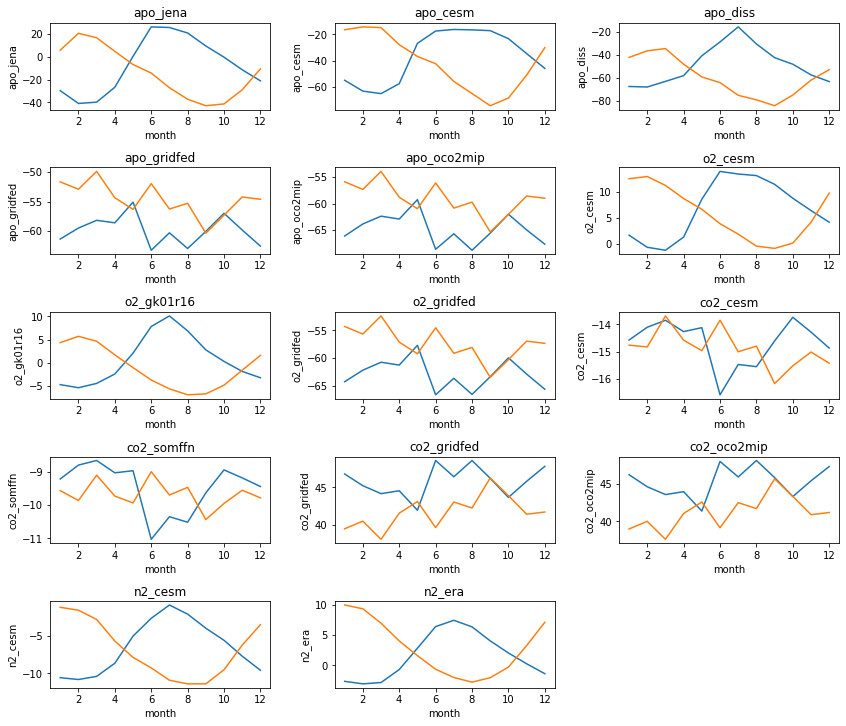

In [28]:
# seasonal climatology

fig, axs = plt.subplots(nrow, ncol, figsize=(12, 12), squeeze=False)

for n, v in enumerate(sno_vars):
    ip, jp = np.unravel_index(n, axs.shape)
    
    ax = axs[ip, jp]
    for stn in station_plot_list:
        ds_seas=station_records[stn][v].groupby('time.month').mean('time')
        ds_seas.plot(ax=ax)
    ax.set_title(v)

plt.tight_layout();    

for n in range(n+1, nrow*ncol):
    ip, jp = np.unravel_index(n, (nrow, ncol))
    axs[ip, jp].remove()
    